## Topic classifier using BERT

Development for a practice topic classifier on column (gpt_topic) using DistillBERT with head and tail tokens long-doc policy.

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from dotenv import load_dotenv
import os
import transformers
load_dotenv()  # looks for .env in current directory or parent
print(torch.__version__)
print(torch.cuda.is_available())


c:\Users\rhrou\miniconda3\envs\torch-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1
True


#### Sample a dataset via query + tokenize

In [2]:
# Connect to server 
import psycopg2
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cur = conn.cursor()

# Do our join in database
cur.execute(f"""
           SELECT gpt_topic,
           b.maintext
           FROM mm_framing_full a
           JOIN newsarticles b ON a.url = b.url
           ORDER BY RANDOM()
            LIMIT 30000
            """)

result= cur.fetchall()

print(cur.description)

cur.close()
conn.close()

df = pd.DataFrame(result, columns=["gpt_topic", "article_text"])
df.head()

del result

(Column(name='gpt_topic', type_code=25), Column(name='maintext', type_code=25))


In [3]:
## ESSENTIAL DATA FILTERING
# REMOVE rows that have less than 10 observations for the topic

counts = df.groupby('gpt_topic')['gpt_topic'].transform('count')

# 2. Filter the DataFrame
df_filtered = df[counts >= 10].copy()

# 3. Check the result
print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"Topics removed: {df['gpt_topic'].nunique() - df_filtered['gpt_topic'].nunique()}")
df = df_filtered

del df_filtered, counts

Original rows: 30000
Filtered rows: 29538
Topics removed: 76


In [4]:
from transformers import AutoTokenizer, DistilBertTokenizer

# choosing a base tokenizer model, this won't 
model = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model)

test_text = "I'm a big blue watermelon"

encoded_input = tokenizer(test_text)
print(encoded_input)

# generally want to keep the tokenizations in a separate variable rather than adding them back to the dataframe (for efficiency, taking advantage of the batching features of the huggingface tokenizer)

encodings = tokenizer(df['article_text'].tolist(),                      # we opt to dynamically do padding later with head/tail strategy
                      # hence we also don't need truncation here
                      )

{'input_ids': [101, 1045, 1005, 1049, 1037, 2502, 2630, 2300, 10199, 2239, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors


In [5]:

df['gpt_topic'].nunique()


65

### Implement head/tail cutting strategy to mesh into 512 token limit

Go for a balance of head - 320, and tail - 190 to balance beginning and ending article context

In [6]:
import statistics as stat

# Firstly, how many are we gonna change
lengths = [len(encoding) for encoding in encodings['input_ids']]
print(stat.mean(lengths))

exceed_count = len(list(filter(lambda l: l > 512, lengths)))
print(exceed_count)

# How many are super short? out of curiosity
short_count = len(list(filter(lambda l: l < 150, lengths)))
print(short_count)

print(len(encodings['input_ids']))


531.8111246529894
13478
7647
29538


In [7]:
# Code to set the unique head and tail of the articles
head_len = 320
tail_len = 190
content_len = head_len + tail_len          
max_len = content_len + 2  # [CLS] + [SEP]      

cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

for i, ids in enumerate(encodings["input_ids"]):
    # ClS and Sep Id's are present in tokenized values, so do this
    if len(ids) >= 2 and ids[0] == cls_id and ids[-1] == sep_id:
        ids = ids[1:-1]

    # Head+tail on the content tokens
    if len(ids) > content_len:
        head = ids[:head_len]
        tail = ids[-tail_len:]
        ids = head + tail

    # Add specials back
    ids = [cls_id] + ids + [sep_id]

    # Build attention mask (1 for real tokens)
    mask = [1] * len(ids)

    # Pad (or truncate)
    if len(ids) < max_len:
        pad_n = max_len - len(ids)
        ids = ids + [pad_id] * pad_n
        mask = mask + [0] * pad_n
    else:
        ids = ids[:max_len]
        mask = mask[:max_len]

    # Write back
    encodings["input_ids"][i] = ids
    encodings["attention_mask"][i] = mask

# quick sanity check
for ids, mask in zip(encodings["input_ids"][:10], encodings["attention_mask"][:10]):
    assert len(ids) == 512 and len(mask) == 512
    print(ids[:3], sum(mask))

[101, 1037, 2304] 512
[101, 3481, 23520] 128
[101, 2009, 1521] 512
[101, 1037, 3066] 19
[101, 3533, 7226] 512
[101, 2225, 29466] 512
[101, 9553, 1010] 240
[101, 1037, 2610] 452
[101, 1037, 12058] 512
[101, 8645, 18981] 39


### PyTorch Dataset Creation

Using `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`

[Pytorch data tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [8]:
# We first have to convert our label in the df into a categorical so it processes correctly
df['topic_cat'] = df['gpt_topic'].astype('category')
label_ids = df['topic_cat'].cat.codes
id_to_label = list(df['topic_cat'].cat.categories)
label_to_id = {label: i for i, label in enumerate(id_to_label)}

# so label_ids is our list of integer representations of our original topic labels

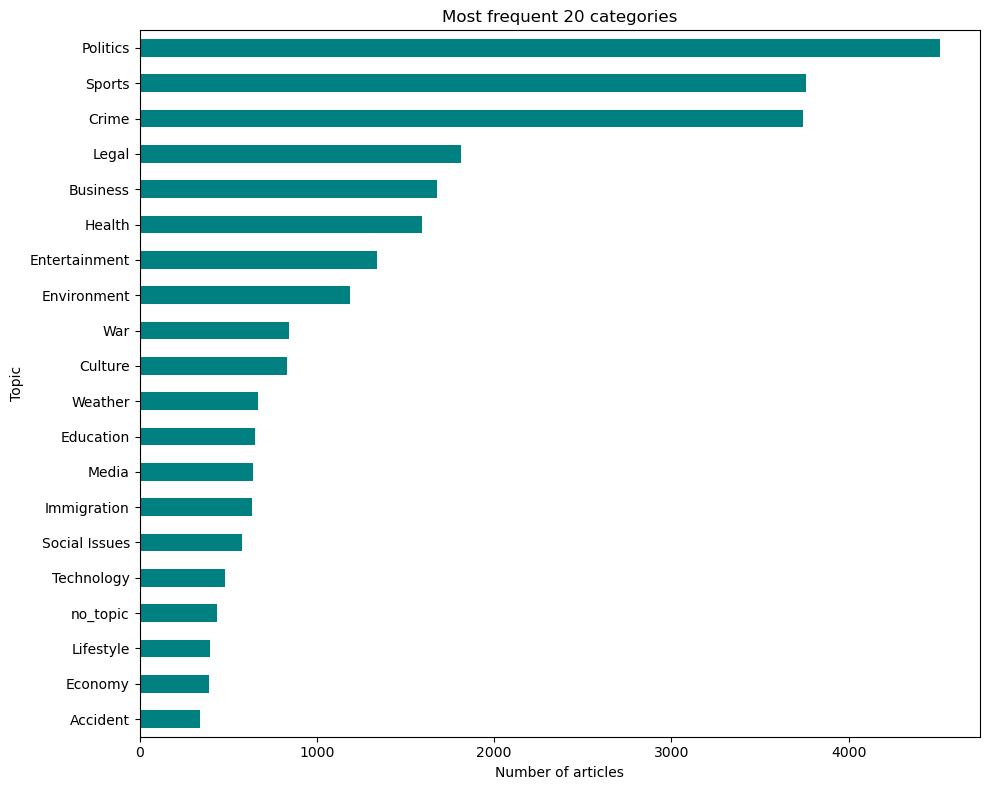

In [9]:
# Examine distribution of value counts of labels
df['topic_cat'].value_counts

import matplotlib.pyplot as plt

# 1. Calculate counts and take the top 20
top_topics = df['topic_cat'].value_counts().head(20)

# 2. Create a horizontal bar chart
# We sort_values() at the end so the highest count is at the top of the chart
top_topics.sort_values().plot(kind='barh', figsize=(10, 8), color='teal')

plt.title('Most frequent 20 categories') # "The 20 most frequent categories"
plt.xlabel('Number of articles') # "Number of articles"
plt.ylabel('Topic')
plt.tight_layout()

plt.savefig('plots/topic_distribution.png')

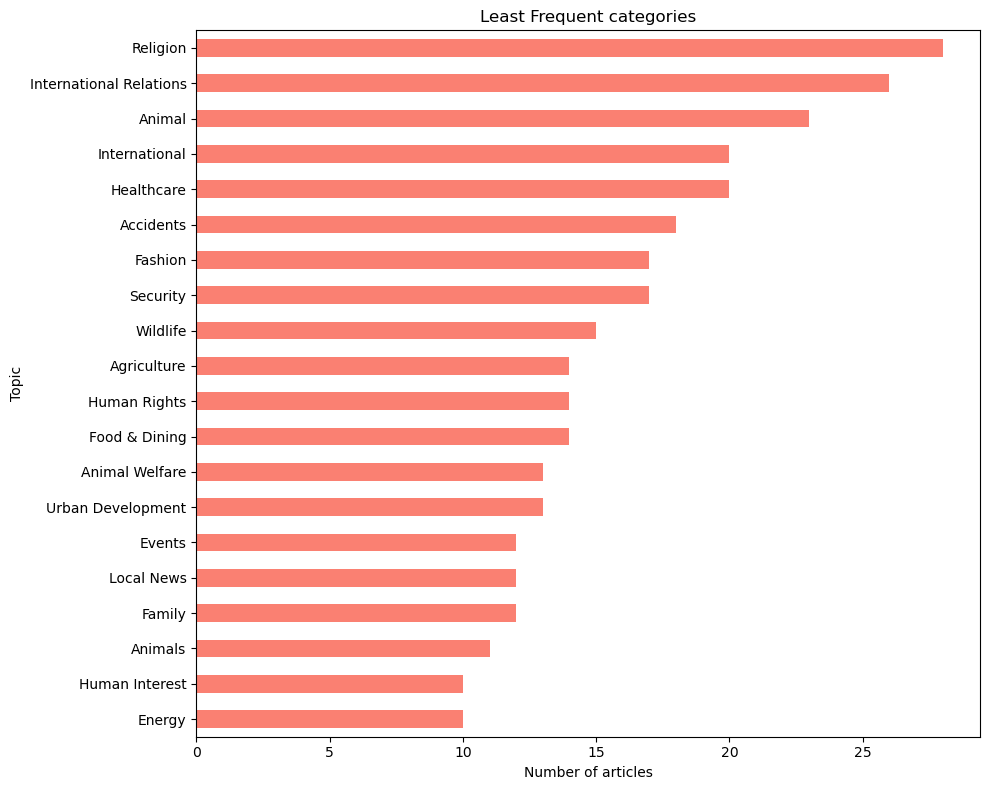

In [10]:
# 1. Get the 20 least frequent categories
# .value_counts() sorts by descending order by default, so .tail(20) gets the smallest
bottom_topics = df['topic_cat'].value_counts().tail(20)

# 2. Create the horizontal bar chart
# We sort them so the smallest bars are at the top for better readability
bottom_topics.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8), color='salmon')

plt.title('Least Frequent categories') # The 20 least frequent categories
plt.xlabel('Number of articles')
plt.ylabel('Topic')
plt.tight_layout()

plt.savefig('plots/least_frequent_topics.png')

In [ ]:
# Modifying the below to record the raw text, but filter this out in batch processing

from torch.utils.data import Dataset

class NewsArticleDataset(Dataset):
    def __init__(self, encodings, label_ids: pd.Series):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = label_ids.to_list() # convert to list for indexing robustness  
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        # for transformer style training, generally return a dict with keys that match what your model expects
        dict_to_return = {'input_ids': torch.tensor(self.input_ids[idx], dtype = torch.long), # convert to tensors, 64-bit integer (long) dtype 
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype = torch.long),
            'labels': torch.tensor(self.labels[idx], dtype =torch.long)}
        return dict_to_return
        


### Creating the test/train/val split

Since we have so many unique classes (100+) it seems best to stratify our data split to balance class distributions.

Can use `sklearn.model_selection.train_test_split`

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# integer-coded labels aligned with encodings order
labels = np.array(label_ids, dtype=np.int64) # numpy array

N = len(labels)
idx = np.arange(N)

# 80/10/10 split (train/val/test), stratified
train_idx, temp_idx = train_test_split(
    idx,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=labels # as array
)

# Run it again on the temp test set to get the val set
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,                    # half of 20% -> 10% val, 10% test
    random_state=42,
    shuffle=True,
    stratify=labels[temp_idx]
)

# Build ONE dataset, then slice with Subset
full_df = NewsArticleDataset(encodings, label_ids)  # or NewsArticleDataset(encodings, labels)
train = Subset(full_df, train_idx) # basically does what it says on the tin
val   = Subset(full_df, val_idx)
test  = Subset(full_df, test_idx)

print(len(train), len(val), len(test))



23626 2953 2954


### Creating the data loader

Knobs start appearing to be tweaked here, large number of options

In [67]:
# sanity check the get item method on data set class
full_df.__getitem__(2)

{'input_ids': tensor([  101,  2508,  1998,  7673, 13675, 26607,  2100,  1010,  1996,  3008,
          1997,  1996,  4345,  2152,  2082,  1010,  2020,  7331,  2006,  9857,
          1010,  2258,  1023,  1010,  2044,  2027,  2020,  2169,  7979,  1997,
         26097, 16042, 17298, 13900,  2121,  1012,  1996,  3008,  1005,  2365,
          2001,  7331,  2000,  2166,  1999,  3827,  2197,  2095,  2005,  1996,
          5008,  2008,  2730,  2176,  2493,  1012,  1996, 13675, 26607,  7274,
          2020,  5496,  1997,  2025,  2893,  2037,  2365,  2393,  1998,  2025,
          7919, 12329,  1037,  3282,  2008,  2001,  2109,  1999,  1996,  5008,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [68]:
# Creating the data loader 
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          num_workers=0, # increase this later on
                          shuffle = True, 
                          pin_memory= True)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True)


In [69]:
# Another sanity check, confirming shapes match expectations

# grab a batch using iterator next()
batch = next(iter(train_loader))

batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape

# 32 (batch_size) X (number of tokens) = like a spreadsheet with all our tokens and 32 examples


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [29]:
# Also quickly check dtypes
batch["input_ids"].dtype, batch["attention_mask"].dtype, batch["labels"].dtype


(torch.int64, torch.int64, torch.int64)

### Load Model and set device

In [30]:
# To avoid writing a head we can load it manually
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=67)
model.to('cuda')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [31]:
# Run through a mini one-example batch of what the model is actually doing and examine outputs, loss, logits, 

import torch

batch = next(iter(train_loader))
batch = {k: v.to("cuda") for k, v in batch.items()}

model.eval()
with torch.no_grad(): # do no grad so we don't build up memory on the GPU accidently
    outputs = model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"],
    )
    loss = outputs.loss
    logits = outputs.logits

print(loss.item())

logits = outputs.logits  # shape: (batch_size, num_labels)

outputs


4.239929676055908


SequenceClassifierOutput(loss=tensor(4.2399, device='cuda:0'), logits=tensor([[-0.0689,  0.1553,  0.0723,  ...,  0.1338,  0.0356, -0.0094],
        [-0.1018,  0.1129,  0.1078,  ...,  0.0980,  0.0953, -0.0158],
        [-0.1129,  0.1195,  0.0941,  ...,  0.1297,  0.0490, -0.0610],
        ...,
        [-0.1098,  0.1301,  0.1045,  ...,  0.1317,  0.0568,  0.0060],
        [-0.1136,  0.1345,  0.1248,  ...,  0.1211,  0.0228, -0.0097],
        [-0.1195,  0.1322,  0.0503,  ...,  0.0851,  0.0606, -0.0313]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [32]:
# clearing memory
del outputs, logits, loss, batch
torch.cuda.empty_cache()


In [33]:
# checking memory usage by cuda
torch.cuda.memory_summary()


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 271177 KiB |    825 MiB |   5738 MiB |   5474 MiB |\n|       from large pool | 270720 KiB |    824 MiB |   5698 MiB |   5434 MiB |\n|       from small pool |    457 KiB |      1 MiB |     40 MiB |     40 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 271177 KiB |    825 MiB |   5738 MiB |   5474 MiB |\n|       from large pool | 270720 KiB |    824 MiB |

### Setting Loss and Optimizer before training

Define optimizer as AdamW (a fine choice for now)
Set an LR scheduler or define manually, setting a value

In [34]:
# set optimizer  and LR
optimizer = torch.optim.AdamW(lr=2e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize

### Training

We use the same structure as in a linear regression torch training loop but we instead, with transformers, train over batches from the DataLoader, moving each batch to the GPU, and the model can compute loss internally when you pass "labels" object.


In [35]:
# for a clean state, hard reset the GPU state
import torch, gc
gc.collect()
torch.cuda.empty_cache() 

In [36]:
epochs = 50

# for epoch in range(epochs):
#     model.train()

#     running_loss = 0.0

#     for batch in train_loader:
#         # 1) move batch to GPU
#         batch = {k: v.to("cuda") for k, v in batch.items()}

#         # 2) forward pass 
#         outputs = model(
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"] # had a rough comma here b4
#         )

#         loss = outputs.loss # default loss from the HF auto model, likely cross entropy
#         running_loss += loss.item()

#         # 3) zero grad
#         optimizer.zero_grad()

#         # 4) backward
#         loss.backward()

#         # 5) step
#         optimizer.step()

#     # ---- validation ----
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             batch = {k: v.to("cuda") for k, v in batch.items()}
#             outputs = model(
#                 input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 labels=batch["labels"],
#             )
#             val_loss += outputs.loss.item()

#             logits = outputs.logits
#             preds = logits.argmax(dim=-1)
#             correct += (preds == batch["labels"]).sum().item()
#             total += batch["labels"].size(0)

#     print(
#         f"Epoch {epoch} | train_loss={running_loss/len(train_loader):.4f} "
#         f"| val_loss={val_loss/len(val_loader):.4f} | val_acc={correct/total:.4f}"
#     )


### Evaluating and re-adjusting model approach

Seems like training is failing silently given that validation accuracy maxes out at epoch 0, a major risk specified in karpathy's recipe for training NNs. I should assume either overfitting or a pipeline/data issue until proven otherwise. To do this, we should build some paranoia checks.

#### Paranoia check 1: "set up the full skeleton + get dumb baselines"
Find out
* Majority-class accuracy
* Random baseline
* "input-independent baseline"

Having re-checked the code, I don't believe it is a mis-labelling issue- label_ids match up with encodings via index. 

In [37]:
df.describe()
# we correctly specified 67 unique labels

,gpt_topic,article_text,topic_cat
count,29533,29533,29533
unique,65,28937,65
top,Politics,BALTIMORE-- After a cloudy and mild Friday acr...,Politics
freq,4384,18,4384


In [38]:
for i in range(5):
    print(df['article_text'][i])
    print(df['gpt_topic'][i])
    
# these labels make sense

NEWYou can now listen to Fox News articles!
A massive car crash involving 72 vehicles in Farmersville, Illinois, Monday morning left at least six people dead and 37 people injured, police said.
According to Illinois State Police, the surviving victims – whose ages ranged between 2 years and 80 years old – were transported to local hospitals with various injuries. Some of whom are said to be in critical condition.
"At 10:55 a.m. there was a crash on northbound Interstate 55 at Milepost 76. At the same time, there were numerous crashes on southbound Interstate 55 at Milepost 76. The crashes occurred within a two-mile stretch — from roughly Milepost 76 to Milepost 78," the police statement read.
It continued: "Reports show there are six fatalities, all occurring in the northbound lanes. At this time, one decedent has been identified as 88-year-old Shirley Harper of Franklin, WI. The Montgomery County Corner’s Office is working diligently to identify the other five individuals and notify t

In [39]:
n_topics = 8
print(f"top {n_topics} most frequent classes proportion")
print(sum(df['topic_cat'].value_counts().iloc[:n_topics])/len(df)*100)

df['topic_cat'].value_counts().iloc[:n_topics]

# we're likely not experiencing just random baseline or input independent baseline, in fact, in this environment, 67% accuracy isn't bad, but it's concerning why it isn't improving

# model may just be learning frequent classes but not the harder more rare classes. This is probably both a data issue and a model (generalization) issue.

top 8 most frequent classes proportion
66.1090982968205


topic_cat
Politics         4384
Crime            3889
Sports           3737
Legal            1794
Business         1678
Health           1528
Entertainment    1292
Environment      1222
Name: count, dtype: int64

### Paranoia check 2: "overfit one batch"

Taking 16-64 examples and confirm I can drive loss near ~0 and accuracy to 100%. If not, something is wrong in labels, batching or model inputs. Otherwise, pipeline is fine and I'm looking at generalization issues or perhaps too many labels to choose from. 

Looking for:
* training loss goes near zero
* training accuracy goes near 100%
* predictions become stable and correct

In [40]:
# reload model as a clean slate
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=67)
model.to('cuda')

# re-create optimizer 
optimizer = torch.optim.AdamW(lr=1e-4, # temp increase for this quick test
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze randomness and fix one batch
fixed_batch = next(iter(train_loader))
fixed_batch = {k: v.to("cuda") for k, v in batch.items()}

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# train on this batch for many steps

# put into training mode
#model.train()

#running_loss = 0.0

# for step in range(800):
    
#     # forward pass
#     outputs = model(
#             input_ids=fixed_batch["input_ids"],
#             attention_mask=fixed_batch["attention_mask"],
#             labels=fixed_batch["labels"]  
#     )
    
#     # find loss
#     loss = outputs.loss
#     # running loss
#     running_loss += loss.item()
    
#     # backprop + optimizer step
#     optimizer.zero_grad()
    
#     loss.backward()
    
#     optimizer.step()
    
#     if step % 50 == 0 or step <= 10:
#         logits = outputs.logits
#         preds = logits.argmax(dim=-1)
#         acc = (preds == fixed_batch["labels"]).float().mean().item()
#         print(f"Epoch {step} | {loss.item()} | {running_loss/(step+1)} ")
#         print(f"acc: {acc}")

# # these results looks good, we're overfitting correctly

Epoch 0 | 4.165653228759766 | 4.165653228759766 
acc: 0.0
Epoch 1 | 3.9975008964538574 | 4.0815770626068115 
acc: 0.25
Epoch 2 | 3.704087734222412 | 3.9557472864786782 
acc: 0.5
Epoch 3 | 3.3123347759246826 | 3.7948941588401794 
acc: 1.0
Epoch 4 | 3.1237332820892334 | 3.66066198348999 
acc: 1.0
Epoch 5 | 2.818068265914917 | 3.520229697227478 
acc: 1.0
Epoch 6 | 2.467593193054199 | 3.3698530537741527 
acc: 1.0
Epoch 7 | 2.2516863346099854 | 3.2300822138786316 
acc: 1.0
Epoch 8 | 2.0234427452087402 | 3.096011161804199 
acc: 1.0
Epoch 9 | 1.8751627206802368 | 2.973926317691803 
acc: 1.0
Epoch 10 | 1.6460140943527222 | 2.8532070246609775 
acc: 1.0
Epoch 50 | 0.01788775809109211 | 0.8543973546109948 
acc: 1.0
Epoch 100 | 0.005726194009184837 | 0.4371539797532455 
acc: 1.0
Epoch 150 | 0.0027204686775803566 | 0.29394421906099466 
acc: 1.0
Epoch 200 | 0.0021151327528059483 | 0.22146429155028857 
acc: 1.0
Epoch 250 | 0.0015013266820460558 | 0.17766365750374613 
acc: 1.0
Epoch 300 | 0.0007846929

Model is training correctly, and reaches 100% accuracy on a sample test batch of size 32 within 4 epochs.
So wiring is correct, model can memorize a fixed batch, earlier plateau is not a bug in batching/labels/loss/backprop.

### Consolidating data distributions / labels 

67 classes is honestly nuts. Not sure how many of these are truly useful, we should consolidate them down to say ~20 or so labels.

In [42]:
# Set the max rows to 100 (or any number higher than 62)
pd.set_option('display.max_rows', 100)

# Now run your command
print(df['topic_cat'].value_counts()[:62])

topic_cat
Politics                     4384
Crime                        3889
Sports                       3737
Legal                        1794
Business                     1678
Health                       1528
Entertainment                1292
Environment                  1222
Culture                       828
War                           821
Education                     685
Weather                       669
Media                         661
Social Issues                 627
Immigration                   626
Technology                    512
no_topic                      460
Lifestyle                     420
Economy                       381
Accident                      344
Science                       263
Safety                        203
Disaster                      190
Transportation                183
Community                     178
Labor                         174
Travel                        157
Finance                       130
Infrastructure                124
Obit

In [12]:
category_mapping = {
    # 1. Politics & Global Affairs (Added 'Government')
    'Politics': 'Politics',
    'International Relations': 'Politics',
    'International': 'Politics',
    'Government': 'Politics',

    # 2. Crime & Safety
    'Crime': 'Crime & Safety',
    'Safety': 'Crime & Safety',
    'Public Safety': 'Crime & Safety',
    'Security': 'Crime & Safety',
    'Cybersecurity': 'Crime & Safety',

    # 3. Legal
    'Legal': 'Legal',

    # 4. Business & Economy (Added 'Consumer')
    'Business': 'Business & Economy',
    'Economy': 'Business & Economy',
    'Economics': 'Business & Economy',
    'Finance': 'Business & Economy',
    'Labor': 'Business & Economy',
    'Consumer': 'Business & Economy',

    # 5. Sports
    'Sports': 'Sports',

    # 6. Health
    'Health': 'Health',
    'Healthcare': 'Health',

    # 7. Entertainment (Added 'Celebrity')
    'Entertainment': 'Entertainment',
    'Celebrity': 'Entertainment',

    # 8. Lifestyle & Culture
    'Culture': 'Lifestyle & Culture',
    'Lifestyle': 'Lifestyle & Culture',
    'Travel': 'Lifestyle & Culture',
    'Food': 'Lifestyle & Culture',
    'Arts': 'Lifestyle & Culture',
    'Fashion': 'Lifestyle & Culture',
    'History': 'Lifestyle & Culture',
    'Religion': 'Lifestyle & Culture',
    'Family': 'Lifestyle & Culture',
    'Human Interest': 'Lifestyle & Culture',
    'Obituary': 'Lifestyle & Culture',

    # 9. Environment & Nature (Added 'Animals')
    'Environment': 'Environment & Nature',
    'Wildlife': 'Environment & Nature',
    'Animal Rights': 'Environment & Nature',
    'Animal': 'Environment & Nature',
    'Animals': 'Environment & Nature',
    'Animal Welfare': 'Environment & Nature',
    'Agriculture': 'Environment & Nature',

    # 10. War & Conflict
    'War': 'War & Conflict',
    'Military': 'War & Conflict',

    # 11. Science & Technology
    'Technology': 'Science & Technology',
    'Science': 'Science & Technology',

    # 12. Disaster & Accidents
    'Accident': 'Disaster & Accidents',
    'Accidents': 'Disaster & Accidents',
    'Disaster': 'Disaster & Accidents',
    'Disasters and Emergencies': 'Disaster & Accidents',
    'Natural Disasters': 'Disaster & Accidents',
    'Natural Disaster': 'Disaster & Accidents',
    'Emergency': 'Disaster & Accidents',

    # 13. Social Issues (Added 'Humanitarian')
    'Social Issues': 'Social Issues',
    'Social': 'Social Issues',
    'Society': 'Social Issues',
    'Community': 'Social Issues',
    'Charity': 'Social Issues',
    'Human Rights': 'Social Issues',
    'Humanitarian': 'Social Issues',

    # 14. Infrastructure & Transport
    'Transportation': 'Infrastructure & Transport',
    'Infrastructure': 'Infrastructure & Transport',
    'Housing': 'Infrastructure & Transport',
    'Urban Development': 'Infrastructure & Transport',

    # 15. Independent Mid-Sized Categories
    'Weather': 'Weather',
    'Education': 'Education',
    'Media': 'Media',
    'Immigration': 'Immigration',

    # 16. Handling Nulls/Other
    'no_topic': 'Other/Unknown',
    'No_topic': 'Other/Unknown'
}

In [14]:
# Create the new column
df['cleaned_topic'] = df['topic_cat'].map(category_mapping)

# IMPORTANT: .map() converts anything NOT in the dictionary to NaN (missing).
# If you have topics in your data that are NOT in the list above, fill them with the original value:
df['cleaned_topic'] = df['cleaned_topic'].fillna(df['topic_cat'])

# set dtype
df['cleaned_topic'] = df['cleaned_topic'].astype('category')

# Check your new reduced value counts
print(df['cleaned_topic'].value_counts())

df['cleaned_topic'].describe()

cleaned_topic
Politics                      4561
Crime & Safety                4110
Sports                        3762
Business & Economy            2406
Lifestyle & Culture           1897
Legal                         1816
Health                        1615
Entertainment                 1342
Environment & Nature          1315
Social Issues                  963
War & Conflict                 885
Science & Technology           690
Disaster & Accidents           681
Weather                        671
Education                      653
Media                          641
Immigration                    636
Other/Unknown                  467
Infrastructure & Transport     379
Food & Dining                   14
Local News                      12
Events                          12
Energy                          10
Name: count, dtype: int64


count        29538
unique          23
top       Politics
freq          4561
Name: cleaned_topic, dtype: object

Now let's reload the dataloaders with this new set of labels

In [45]:
# rereate label_ids mapping (string --> int)
label_ids = df['cleaned_topic'].cat.codes
id_to_label = list(df['cleaned_topic'].cat.categories)
label_to_id = {label: i for i, label in enumerate(id_to_label)}
label_to_id

{'Business & Economy': 0,
 'Crime & Safety': 1,
 'Disaster & Accidents': 2,
 'Education': 3,
 'Entertainment': 4,
 'Environment & Nature': 5,
 'Food & Dining': 6,
 'Health': 7,
 'Immigration': 8,
 'Infrastructure & Transport': 9,
 'Legal': 10,
 'Lifestyle & Culture': 11,
 'Media': 12,
 'Other/Unknown': 13,
 'Politics': 14,
 'Real Estate': 15,
 'Science & Technology': 16,
 'Social Issues': 17,
 'Sports': 18,
 'War & Conflict': 19,
 'Weather': 20}

In [46]:
# recreate the dataset

# Redo the test_train split since indices have to be stratified
# integer-coded labels aligned with encodings order
labels = np.array(label_ids, dtype=np.int64) # numpy array

N = len(labels)
idx = np.arange(N)

# 80/10/10 split (train/val/test), stratified
train_idx, temp_idx = train_test_split(
    idx,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=labels # as array
)

# Run it again on the temp test set to get the val set
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,                    # half of 20% -> 10% val, 10% test
    random_state=42,
    shuffle=True,
    stratify=labels[temp_idx]
)

# Build ONE dataset, then slice with Subset
full_df = NewsArticleDataset(encodings, label_ids)  # or NewsArticleDataset(encodings, labels)
train = Subset(full_df, train_idx) # basically does what it says on the tin
val   = Subset(full_df, val_idx)
test  = Subset(full_df, test_idx)
print(len(train), len(val), len(test))


23626 2953 2954


In [47]:
# recreate the data loader, they rely on dataset + indices
batch_size = 32

train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          num_workers=0, # increase this later on
                          shuffle = True, 
                          pin_memory= True)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True)

### New training loop after debugs/changes

In [48]:
# reset model 
# recreate the model head 
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=19)
model.to('cuda')

# set optimizer  and LR
optimizer = torch.optim.AdamW(lr=2e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
epochs = 3

# for epoch in range(epochs):
#     model.train()

#     running_loss = 0.0

#     for batch in train_loader:
#         # 1) move batch to GPU
#         batch = {k: v.to("cuda") for k, v in batch.items()}

#         # 2) forward pass 
#         outputs = model(
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"] # had a rough comma here b4
#         )

#         loss = outputs.loss # default loss from the HF auto model, likely cross entropy
#         running_loss += loss.item()

#         # 3) zero grad
#         optimizer.zero_grad()

#         # 4) backward
#         loss.backward()

#         # 5) step
#         optimizer.step()

#     # ---- validation ----
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             batch = {k: v.to("cuda") for k, v in batch.items()}
#             outputs = model(
#                 input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 labels=batch["labels"],
#             )
#             val_loss += outputs.loss.item()

#             logits = outputs.logits
#             preds = logits.argmax(dim=-1)
#             correct += (preds == batch["labels"]).sum().item()
#             total += batch["labels"].size(0)

#     print(
#         f"Epoch {epoch} | train_loss={running_loss/len(train_loader):.4f} "
#         f"| val_loss={val_loss/len(val_loader):.4f} | val_acc={correct/total:.4f}"
#     )

Notes on this training run:
* seems we can work with batch size of 32 reasonably well, dedicated GPU memory around 65%
* we could probably push the epochs further with the above set-up, but now that this is working, it's better to implement some more intelligent improvements

Specifically:
* Early-stopping + best checkpoint (by val_loss)
* Macro-F1 (and accuracy) on validation

### Refined training run #2

In [59]:
# adding in early stopping and model checkpoint (minimizing val_loss)

import copy
import math

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience # how long we wait to see if val improves
        self.min_delta = min_delta
        self.best = math.inf # track best loss, inf on init
        self.bed_epochs = 0
        self.best_state = None
    def step(self, val_loss, model):
        improved = val_loss < (self.best - self.min_delta)
        if improved:
            self.best = val_loss
            self.bad_epochs = 0
            # keep weights in memory for recent best model
            self.best_state = copy.deepcopy(model.state_dict()) # state dict is our parameters
        else:
            self.bed_epochs += 1
        return self.bed_epochs >= self.patience # returns boolean on whether to continue or not

In [60]:
# dedicate GPU memory is growing so lets reset it 
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [61]:
# reset model 
# recreate the model head 
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=19)
model.to('cuda')

# set optimizer  and LR
optimizer = torch.optim.AdamW(lr=2e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [62]:
## FULL TRAINING LOOP WITH MACRO F1 (and accuracy) ON VALIDATION
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

early = EarlyStopper(patience=8, min_delta=0.0)
max_epochs = 15

for epoch in range(max_epochs):
    model.train()

    running_loss = 0.0

    for batch in train_loader:
        # 1) move batch to GPU
        batch = {k: v.to("cuda") for k, v in batch.items()}

        # 2) forward pass 
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"] # had a rough comma here b4
        )

        loss = outputs.loss # default loss from the HF auto model, likely cross entropy
        running_loss += loss.item()

        # 3) zero grad
        optimizer.zero_grad()

        # 4) backward
        loss.backward()

        # 5) step
        optimizer.step()

    # ---- new validation process ----
    model.eval()

    all_preds = []
    all_labels = []
    val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(batch['labels'].detach().cpu().numpy())
            val_loss += outputs.loss.item() 
    val_loss_mean = val_loss / len(val_loader)

            
            
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1_macro = f1_score(all_labels, all_preds, average = "macro")
    val_f1_weighted = f1_score(all_labels, all_preds, average="weighted")
        
    print(
        f"Epoch {epoch} | train_loss_mean ={running_loss/len(train_loader):.3f} "
        f"| val_acc={val_acc:.3f} | val_f1_macro={val_f1_macro:.3f} | val_f1_weighted = {val_f1_weighted:.3f} |"
        f"val_loss = {val_loss_mean:.3f}")
    
    should_stop = early.step(val_loss_mean, model) # should be mean here?
    
    if should_stop:
        print("Early stopping triggered.")
        break    

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
## Getting best model
model.load_state_dict(early.best_state)


AttributeError: 'str' object has no attribute 'load_state_dict'

Notes on this training run:

* Hitting an overfitting wall, which measn we probably do need some regularization
* DistillBERT, being a smaller size than bert base, might lack the size to capture the subtle boundaries between categories



Next steps:

* Explore newer BERT classification models (like zero-shot models that don't need to be pre-trained! investigating `"MoritzLaurer/deberta-v3-base-zeroshot-v2.0"`)

* We could move to a much larger model like bigbird or longformer, but at this point, I'm not convinced that it's actually the truncation that is causing this problem, as topic modelling should be fairly simple

* Implement regularization via dropout probabilities in the config

* Also thinking that we could just inspect the data, is it struggling with very short texts, for instance? are labels correct and can we process them?



In [ ]:
# Let's try it on the test set




### Training Run #3 - testing one-shot classifier model 